## Reading Data and Initial Diagnositics

doc link: https://docs.google.com/document/d/1nm-Ri3gDlla7v0hOZWvn2QswmdoKnWJ8fUnAvNfSv5Y/edit?usp=sharing

In [28]:
# Common Imports
import random
import warnings
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tabulate import tabulate
from sklearn.pipeline import Pipeline
from matplotlib.colors import Normalize
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

In [5]:
# utility function to print the column names and data types for each column in a dataframe
def print_col_types(data: pd.DataFrame) -> None:
    print("\nCols\tData Type")
    print("----\t---------")
    print(data.dtypes)

In [6]:
# read the data and run diagnositics
data = pd.read_csv("skyserver_data.csv")
VIEW_ROWS: int = 5

print(f"Number of Rows: {data.shape[0]}, Number of Columns: {data.shape[1]}\n")

print(f"First {VIEW_ROWS} Rows")
display(data.head(5))
print(f"Last {VIEW_ROWS} Rows")
display(data.tail(5))

print_col_types(data)

Number of Rows: 347046, Number of Columns: 11

First 5 Rows


,u,g,r,i,z,type,mode,flags,feh,teff,logg
0,17.74149,16.59350,16.17159,16.02715,15.93656,6,1,nnnnn,-0.676982,5965.954,4.201272
1,18.99371,18.00112,17.63029,17.50343,17.44212,6,1,nnnnn,-1.313370,5944.153,3.599674
2,17.76598,16.86959,16.54257,16.41686,16.37806,6,1,nnnnn,-1.872914,6328.010,3.970203
3,18.53829,17.55103,17.06516,16.85526,16.74448,6,1,nnnnn,-1.804460,6132.964,3.968426
4,18.95163,17.89401,17.47597,17.31722,17.23473,6,1,nnnnn,-0.957447,5857.972,3.939497


Last 5 Rows


,u,g,r,i,z,type,mode,flags,feh,teff,logg
347041,19.74876,17.92489,17.17177,16.85879,16.65431,6,1,nnBgn,-1.087301,4862.076,4.464107
347042,18.77587,17.12293,16.38808,16.06931,15.89801,6,1,nnnnn,-2.068112,4947.906,1.725994
347043,20.44156,17.98008,16.91404,16.52675,16.30901,6,1,nnnnn,-0.698523,4496.792,4.540200
347044,19.48390,18.31149,17.89681,17.71497,17.63102,6,1,nnnnn,-0.844079,5844.436,4.074500
347045,19.97392,18.33957,17.69984,17.46040,17.33603,6,1,nnnnn,-0.910552,5080.398,1.963508



Cols	Data Type
----	---------
u        float64
g        float64
r        float64
i        float64
z        float64
type       int64
mode       int64
flags     object
feh      float64
teff     float64
logg     float64
dtype: object


In [7]:
# some of the data types are actually class names, but represented as numbers. We will change them to categorical
data_typed = data.astype({'type': 'object', 'mode': 'object'})

print_col_types(data)       #before
print_col_types(data_typed) #after


Cols	Data Type
----	---------
u        float64
g        float64
r        float64
i        float64
z        float64
type       int64
mode       int64
flags     object
feh      float64
teff     float64
logg     float64
dtype: object

Cols	Data Type
----	---------
u        float64
g        float64
r        float64
i        float64
z        float64
type      object
mode      object
flags     object
feh      float64
teff     float64
logg     float64
dtype: object


In [8]:
# utility function to look at the distribution of values for columns
def explore_distribution(col_name: list[str], series: pd.Series, num_bins: int = 20, interval: float = .95) -> None:
    # numeric data
    if series.dtypes == "float64":
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(12, 5)
        fig.suptitle(f"Distribution of {col_name} with and without Extreme Values")

        axs[0].set_title("With Extreme Values")
        axs[0].hist(series, num_bins, label=col_name)
        axs[0].set_xlabel(col_name)
        axs[0].set_ylabel("count")

        # retain interval% of data and remove extreme values (outliers)
        tail = (1 - interval) / 2
        low_q = series.quantile(tail)
        high_q = series.quantile(1 - tail)
        s = series[(series >= low_q) & (series <= high_q)]

        axs[1].set_title("Without Extreme Values")
        axs[1].hist(s, num_bins, label=col_name)
        axs[1].set_xlabel(col_name)
        axs[1].set_ylabel("count")
        
        plt.show()

    # categorical data
    else:
        plt.title(f"Distribution of {col_name}")
        plt.bar([str(x) for x in series.unique()], series.value_counts())
        plt.xlabel(col_name)
        if len(plt.gca().get_xticks()) > 5:
            plt.xticks(rotation=90)
        plt.ylabel("count")
        plt.show()

In [9]:
# utility function to show diagnostic plots and summary details
def show_diagnostic_plots(cols: list[str], data: pd.DataFrame, plots_data: dict = None, plots_only: bool = False, summary_only: bool = False) -> None:
    if plots_only:
        summary_only = False
    elif summary_only:
        plots_only = False
    else:
        plots_only = True
        summary_only = True

    if plots_only:
        for col in cols:
            if (plots_data):
                explore_distribution(col, data[col], **plots_data)
            else:
                explore_distribution(col, data[col])

    if summary_only:
        for col in cols:
            print()
            print(f"DESCRIBING COLUMN {col}")
            print("-"*20)
            print(data[col].describe())
            print()

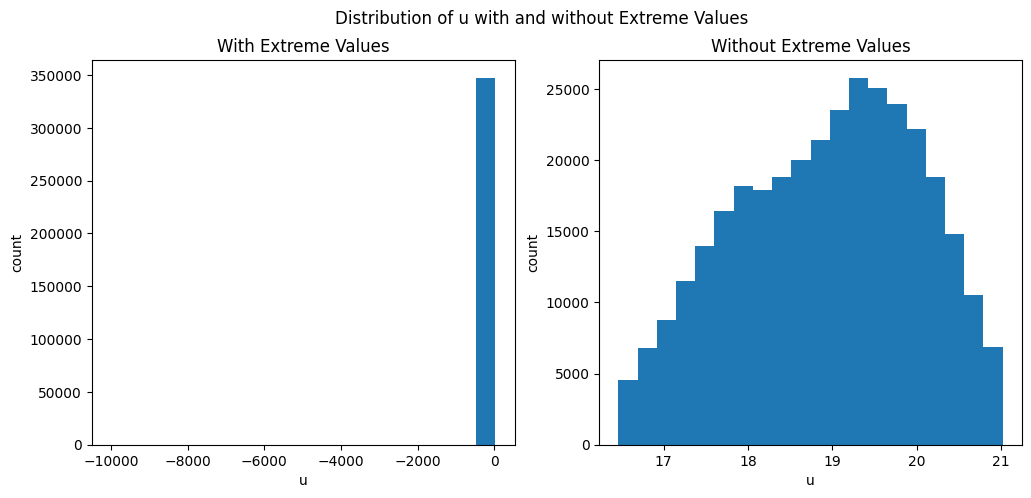

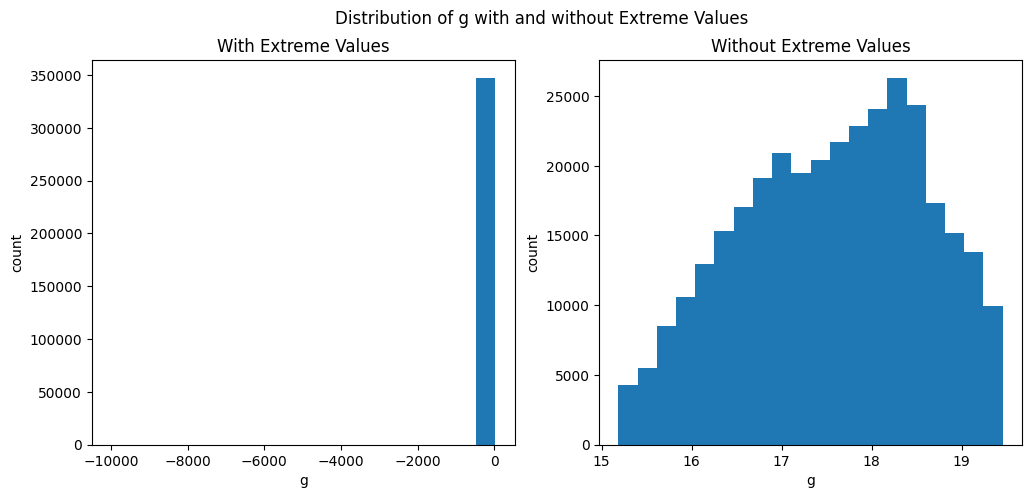

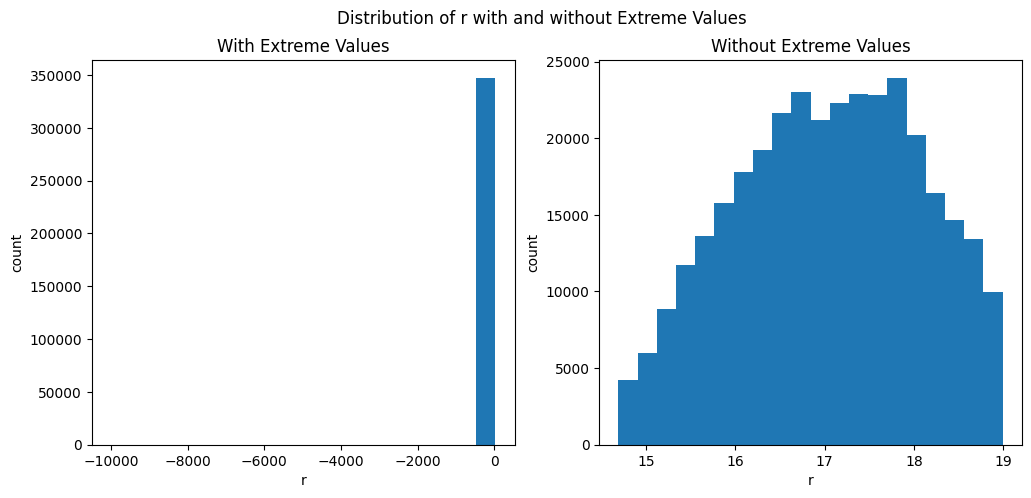

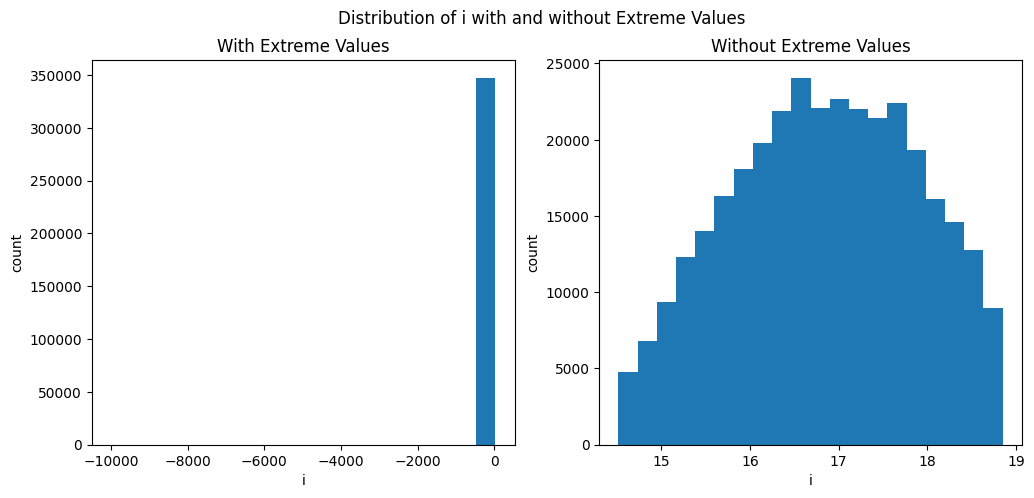

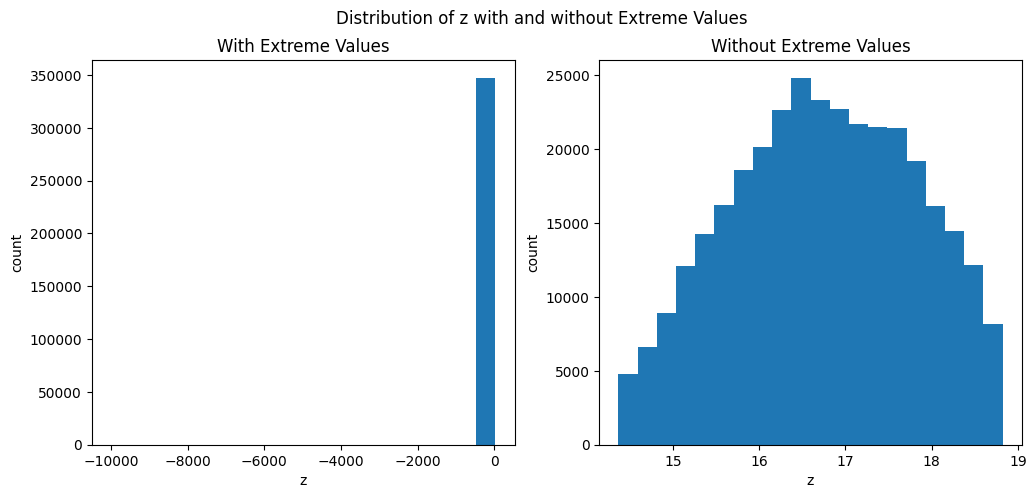

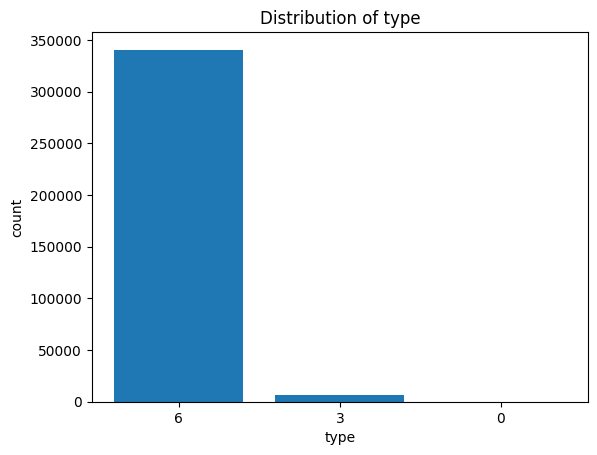

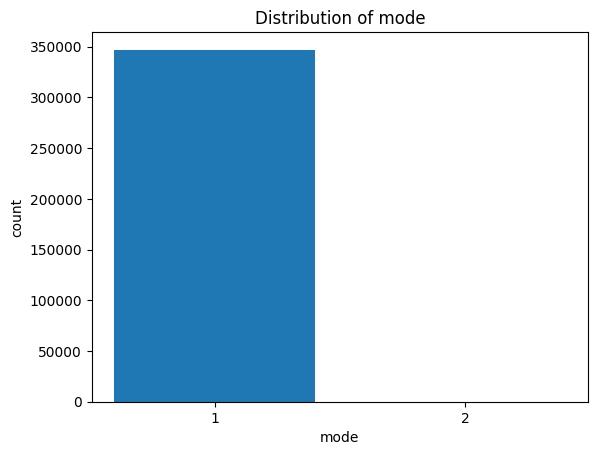

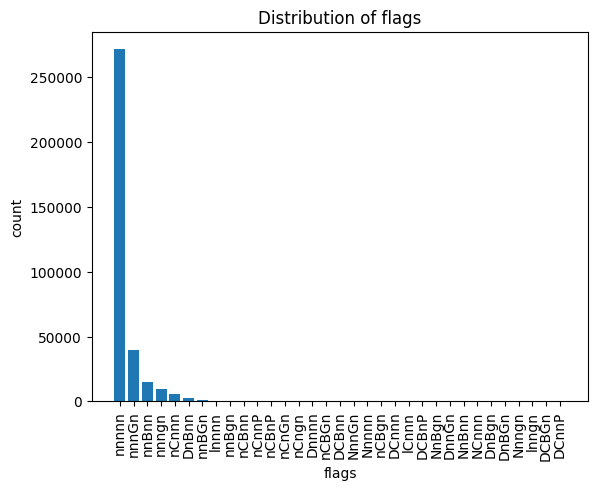

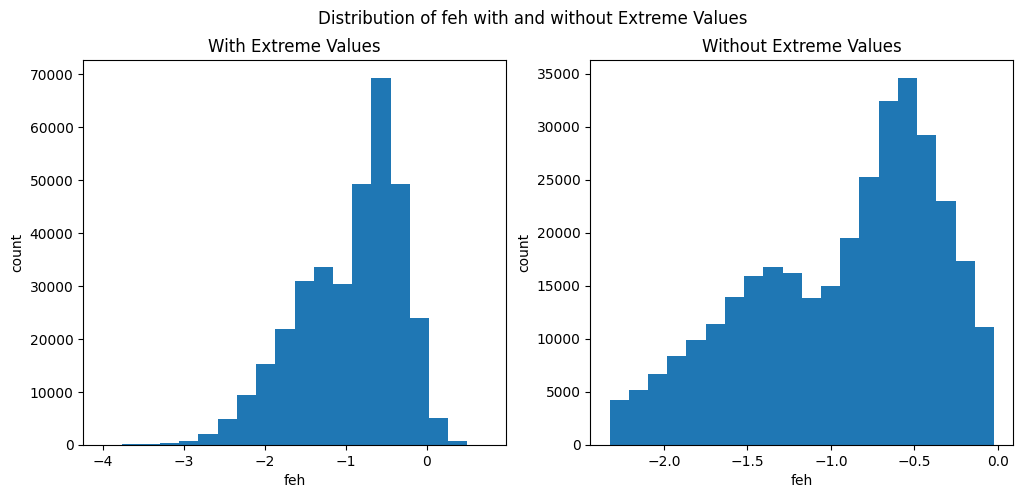

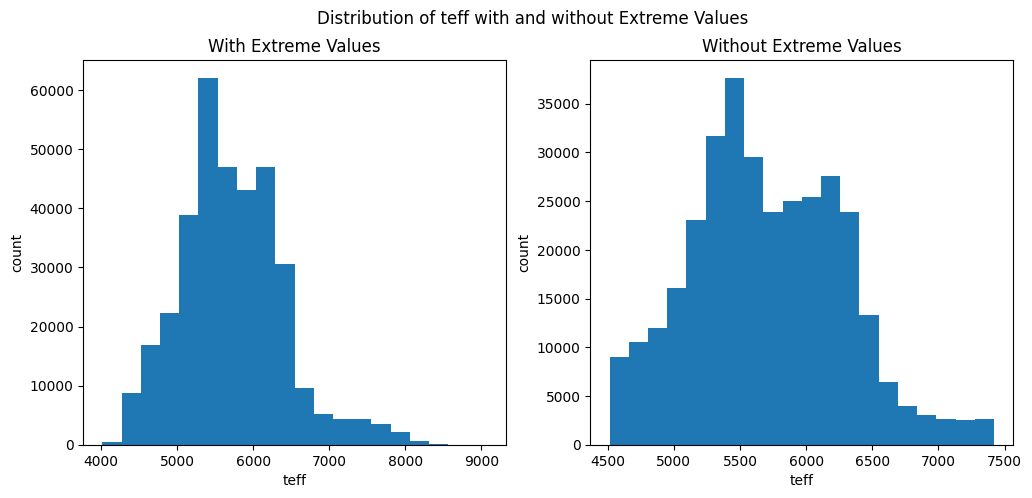

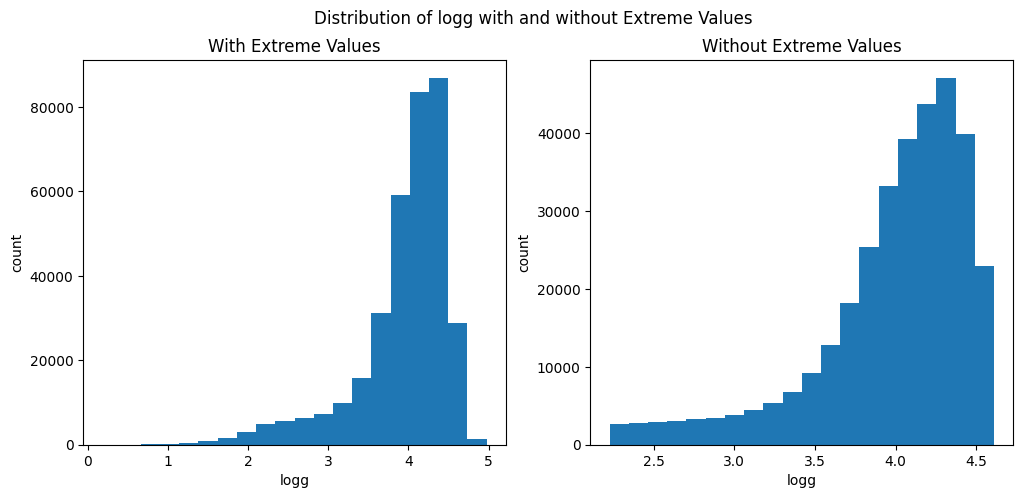


DESCRIBING COLUMN u
--------------------
count    347046.000000
mean         17.913983
std         100.607503
min       -9999.000000
25%          18.032990
50%          19.034985
75%          19.830920
max          30.169740
Name: u, dtype: float64


DESCRIBING COLUMN g
--------------------
count    347046.000000
mean         16.560493
std          99.145857
min       -9999.000000
25%          16.724328
50%          17.640905
75%          18.409045
max          31.284590
Name: g, dtype: float64


DESCRIBING COLUMN r
--------------------
count    347046.000000
mean         16.210533
std          89.971070
min       -9999.000000
25%          16.197682
50%          17.075785
75%          17.885848
max          31.406520
Name: r, dtype: float64


DESCRIBING COLUMN i
--------------------
count    347046.000000
mean         15.839269
std          99.138931
min       -9999.000000
25%          15.991612
50%          16.854195
75%          17.704440
max          31.468180
Name: i, dtype: float

In [10]:
# diagnositc plots
FEATURE_COLS = data_typed.columns.values 
    
show_diagnostic_plots(FEATURE_COLS, data_typed)

In [11]:
# check for any missing data
print(data_typed.isna().sum())

u        0
g        0
r        0
i        0
z        0
type     0
mode     0
flags    0
feh      0
teff     0
logg     0
dtype: int64


## Preprocessing and Feature Engineering
We want our dataset to focus on stars marked as primary with normal SSPP flags.

This means, we only retains rows with
- `type == "6"`
- `mode == "1"`
- `flags == "nnnnn"`

We also want to remove outliers from the color magnitudes. They are represented with the recode value of `-9999`

Lastly, we want to use the color difference between two magnitudes instead of the raw magnitudes themselves.

In [12]:
# flag to display extra plots and summary
VIEW_INFO = False

In [13]:
print("Before Preprocessing")
print("====================")
print(f"Number of Rows: {data_typed.shape[0]}, Number of Columns: {data_typed.shape[1]}\n")

# only keep stars (type == 6) marked as primary (mode == 1) with normal SSPP flags (flags == nnnnn)
# remove the columns used for filtering
wanted_rows_data = data_typed[(data_typed["type"] == 6) & \
                              (data_typed["mode"] == 1) & \
                              (data_typed["flags"] == "nnnnn")].drop(["type", "mode", "flags"], axis=1)

print("After Removing Unwanted Rows")
print("============================")
print(f"Number of Rows: {wanted_rows_data.shape[0]}, Number of Columns: {wanted_rows_data.shape[1]}\n")

if (VIEW_INFO):
    show_diagnostic_plots(wanted_rows_data.columns.values, wanted_rows_data)

# remove outliers in the training attributes. The color filters use -9999 as a special recode.
# We want to remove these rows to prevent skewing our data

tmp = wanted_rows_data[(wanted_rows_data["u"] != -9999.0) & \
                       (wanted_rows_data["g"] != -9999.0) & \
                       (wanted_rows_data["r"] != -9999.0) & \
                       (wanted_rows_data["i"] != -9999.0) & \
                       (wanted_rows_data["z"] != -9999.0)]

# use anomaly detection algorithms to eliminate anomolous data points 
color_mags = tmp.columns.drop(["feh", "teff", "logg"])
Xs = tmp[color_mags]

contamination = 0.40

out1 = [x == 1 for x in IsolationForest(contamination=contamination).fit_predict(Xs)]
out2 = [x == 1 for x in LocalOutlierFactor(contamination=contamination).fit_predict(Xs)]

# drop data points that are identified as outliers by both algorithms
no_outliers_data = tmp[[a or b for a, b in zip(out1, out2)]]

if (VIEW_INFO):
    alg1_outcount = len(out1) - np.sum(out1)
    alg2_outcount = len(out2) - np.sum(out2)
    both_outcount = np.sum([not (a or b) for a, b in zip(out1, out2)])
    plt.bar(["Isolation Forest", "Local Outlier Factor", "Both"], [alg1_outcount, alg2_outcount, both_outcount])
    plt.xlabel("Algorithm")
    plt.ylabel("Number of Anomolous Points Identified")
    plt.title("Anomalous Datapoint Count")
    plt.show()

print("After Removing Outliers")
print("=======================")
print(f"Number of Rows: {no_outliers_data.shape[0]}, Number of Columns: {no_outliers_data.shape[1]}\n")

if (VIEW_INFO):
    show_diagnostic_plots(no_outliers_data.columns.values, no_outliers_data)

# it is more interesting to look at the pairwise color differences instead of the raw magnitudes
# we will engineer the new columns, and remove any redundant columns
complete_data = pd.DataFrame()

# Domain Knowledge: since these filters are arranged in decreasing order of energy, it doesn't make
# sense to consider every permutation, just the combinations
for i in range(len(color_mags)):
    for j in range(i + 1, len(color_mags)):
        high_mag = color_mags[i]
        low_mag = color_mags[j]
        complete_data[f"{high_mag}_{low_mag}"] = no_outliers_data[high_mag] - no_outliers_data[low_mag]

complete_data["feh"] = no_outliers_data["feh"]
complete_data["teff"] = no_outliers_data["teff"]
complete_data["logg"] = no_outliers_data["logg"]

print("After Engineering New Attributes")
print("================================")
print(f"Number of Rows: {complete_data.shape[0]}, Number of Columns: {complete_data.shape[1]}")

if (VIEW_INFO):
    show_diagnostic_plots(complete_data.columns.values, complete_data)

Before Preprocessing
Number of Rows: 347046, Number of Columns: 11

After Removing Unwanted Rows
Number of Rows: 267171, Number of Columns: 8

After Removing Outliers
Number of Rows: 221646, Number of Columns: 8

After Engineering New Attributes
Number of Rows: 221646, Number of Columns: 13


## Data Exploration
After engineering new features, we analyze the training attributes and identify the best features that can be selected based on certain instrinsic statistical properties of the attributes such as:
- Unimodal and Symmetric Distribution
- Low Correlation with other attributes
- Low Multicollinearity

In [14]:
# utility function to produce pairplots for training attributes
def pairplots(df: pd.DataFrame) -> None:
    fig, axs = plt.subplots(nrows=len(df.columns), ncols=len(df.columns), figsize=(18, 18))

    cmap = cm.RdYlBu
    norm = Normalize(vmin=-1, vmax=1)  # normalize for correlation range from -1 to 1
    
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            if i == j:
                # main diagonal -> make histograms
                axs[i, j].hist(df[col1], bins=20, density=True)
                axs[i, j].tick_params(axis="y", labelrotation=45)
            elif i > j:
                # below main diagonal -> make scatter plots
                axs[i, j].scatter(df[col1], df[col2], marker=".")
            else:
                # above main diagonal -> show correlation
                corr = np.corrcoef(df[col1], df[col2])[0, 1]
                axs[i, j].set_facecolor(cmap(norm(corr)))
                axs[i, j].text(0.5, 0.5, f"{corr:.2f}", fontsize=12, ha="center", va="center", transform=axs[i, j].transAxes)
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])

            if i == len(df.columns) - 1:
                axs[i, j].set_xlabel(col2)
            if j == 0:
                axs[i, j].set_ylabel(col1)

plt.show()

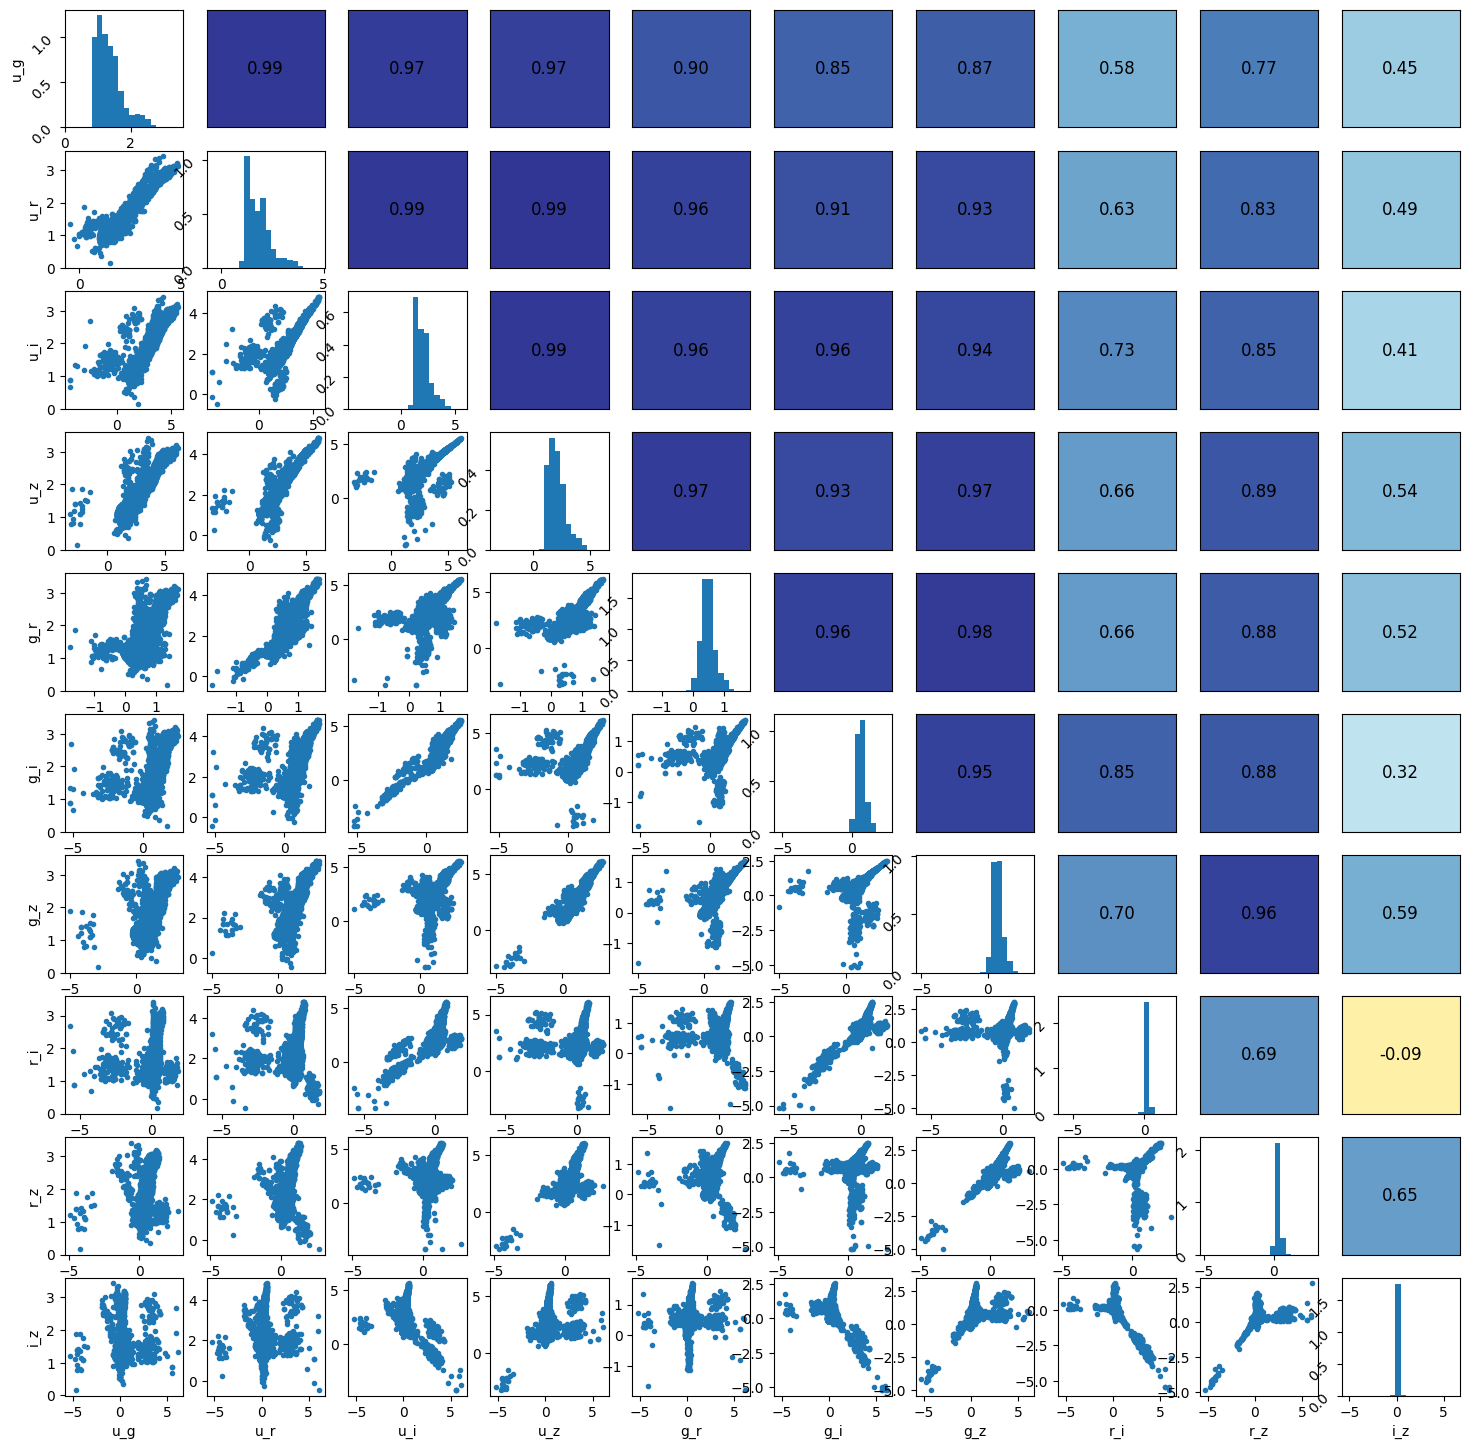

In [15]:
Xs = complete_data.drop(["feh", "teff", "logg"], axis=1)
pairplots(Xs)

## Models
We construct several different regression models to try and fit our data

Model Object API
```Python
{
    "name": str,  # name of the model
    "model_params": dict,  # defined parameters for the model
    "search_grid": dict,  # parameter search grid for the model
    "features": pd.DataFrame,  # input features for the model
    "cv_score": float  # model score
}
```

In [16]:
TARGET_NAME = "teff"

features = complete_data.drop(["feh", "teff", "logg"], axis=1)
target = complete_data[TARGET_NAME]

MODELS = list()

In [17]:
# utility function to take a subset of features based on pairwise correlation
# for a certain threshold
def select_attributes(features: pd.DataFrame, threshold: float = 0.75) -> list[str]:
    column_names = features.columns
    corr_matrix = np.corrcoef(features.T)

    selected_attributes = []

    for i, col in enumerate(column_names):
        keep = True
        for selected in selected_attributes:
            j = column_names.get_loc(selected)
            # check correlation with already selected attributes
            if abs(corr_matrix[i, j]) >= threshold:
                keep = False
                break

        if keep:
            selected_attributes.append(col)

    return selected_attributes

### MLP Regressor

In [26]:
selected_features = select_attributes(features)

# Separate features and target
x = features
y = complete_data[TARGET_NAME]

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Define and train the neural network regression model
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
mlp.fit(x_train_scaled, y_train)

# Evaluate the model
y_pred = mlp.predict(x_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# results comparing predictions with actual values
print("Mean Squared Error:", mse)
print("R2 score:", r2)

Mean Squared Error: 45422.39609311095
R2 score: 0.8935895508596006


### KNN

In [ ]:

selected_features = select_attributes(features)

# Separate features and target
x = features
y = complete_data[TARGET_NAME]

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

# Standardize the features (KNN is sensitive to feature scaling)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Define the base KNN model
knn = KNeighborsRegressor(metric='minkowski', p=2)

# Define the parameter grid for n_neighbors
param_grid = {'n_neighbors': range(1, 31)}  # Testing n_neighbors from 1 to 30

# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train_scaled, y_train)

# Get the best n_neighbors and corresponding model
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_knn_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_knn_model.predict(x_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results (best n_neighbors, and metrics on test set)
print("Best n_neighbors:", best_n_neighbors)
print("Mean Squared Error:", mse)
print("R2 score:", r2)

Best n_neighbors: 40
Mean Squared Error on Test Set: 45349.768537823446
R2 score on Test Set: 0.8936619862249032


### Random Forest Regressor

In [ ]:
# get features and targets
X, y = features[select_attributes(features, 0.8)], target

# define model
rf = RandomForestRegressor(random_state=25)

# define hyperparameter grid
param_grid = {
    "n_estimators": [10, 15],  # number of trees in the forest
    "max_depth": [10, 20],  # max depth of the tree
    "min_samples_split": [5, 10],  # min samples required to split an internal node
    "min_samples_leaf": [1, 2],  # min samples required to be at a leaf node
    "max_features": ["sqrt", "log2"]  # number of features to consider for best split
}

# perform nested cross validation over the defined hyperparameter space
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring="neg_root_mean_squared_error",
                           verbose=2,
                           n_jobs=-1)
score = np.mean(cross_val_score(grid_search, X, y, cv=5))
print("Average Score:", score)

# update models
MODELS.append({
    "name": "Random Forest Regressor",
    "model_params": { "random_state": 25 },
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Average Score: -231.6806623659871


### Elastic Net

In [ ]:
# get features and targets
X, y = features[select_attributes(features, 0.9)], target

# define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First scale the data
    ('en', ElasticNet(selection="random", random_state=25))  # Then apply the ElasticNet Regression
])

# define hyperparameter grid
param_grid = {
    "en__alpha": np.logspace(-3, 2, 10),  # regularization strength
    "en__l1_ratio": np.linspace(0, 1, 10)  # mix between L1 (lasso) and L2 (ridge)
}

# perform nested cross validation over the defined hyperparameter space
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring="neg_root_mean_squared_error",
                           verbose=2,
                           n_jobs=-1)

@ignore_warnings(category=ConvergenceWarning)
def compute_score(grid: GridSearchCV, X: pd.DataFrame, y: pd.Series) -> np.float64:
    return np.mean(cross_val_score(grid, X, y, cv=5))

score = compute_score(grid_search, X, y)
print("Average Score:", score)

# update models
MODELS.append({
    "name": "Elastic Net",
    "model_params": {"selection": "random", "random_state": 25},
    "search_grid": param_grid,
    "features": X,
    "cv_score": score
})

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average Score: -280.38062515345666


In [ ]:
from tabulate import tabulate

table = []
for model in MODELS:
    table.append([model["name"], len(model["features"].columns), model["cv_score"]])

print(tabulate(table, headers=["Model Name", "Number of Features", "Score"]))

Model Name                 Number of Features     Score
-----------------------  --------------------  --------
Random Forest Regressor                     4  -231.681
Elastic Net                                 5  -280.381
